This notebook where does the UV radiation come from in a disc, and how can we better weight the geometry when we compute the radiation force.

In [1]:
import pyagn
import importlib
from pyagn import sed
importlib.reload(sed)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")
import numpy as np
from astropy import units as u
from scipy import integrate
from pyagn import constants

In [39]:
bh = sed.SED(M = 1e8, mdot = 0.6, reprocessing = False)

creating figure.


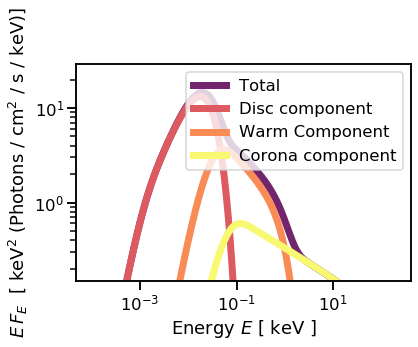

In [40]:
bh.plot_total_flux(1e26)

In [41]:
distance = sed.convert_units(1 * u.Mpc, u.cm)

In [42]:
disc_r_range = np.linspace(bh.corona_radius, bh.gravity_radius, 500)
dr = disc_r_range[1] - disc_r_range[0]
energy_range_erg = bh.ENERGY_RANGE_ERG
energy_range_kev = bh.ENERGY_RANGE_KEV
UV_KEV_CUT_LOW = 0.00387
UV_KEV_CUT_HIGH = 0.06
uv_kev_mask = (energy_range_kev >= UV_KEV_CUT_LOW) & (energy_range_kev <= UV_KEV_CUT_HIGH)
xray_kev_mask = energy_range_kev >= UV_KEV_CUT_HIGH
energy_range_uv_kev = energy_range_kev[uv_kev_mask]
energy_range_uv_erg = energy_range_erg[uv_kev_mask]
energy_range_xray_kev = energy_range_kev[xray_kev_mask]
energy_range_xray_erg = energy_range_erg[xray_kev_mask]

#uv_erg_cut_low = sed.convert_units(UV_KEV_CUT_LOW * u.keV, u.erg)
#uv_erg_cut_high = sed.convert_units(UV_KEV_CUT_HIGH * u.keV, u.erg)
#uv_erg_mask = (energy_range_erg > uv_erg_cut_low) & (energy_range_erg < uv_erg_cut_high)
#energy_range_uv_erg = energy_range_erg[uv_erg_mask]

In [54]:
distance = 1e26
def compute_warm_flux(r):
    flux_r = bh.warm_flux_r(r) # 1 / cm^2 / s
    if (max(flux_r) == 0.):
        return np.zeros(len(bh.ENERGY_RANGE_KEV))
    mask = flux_r > 0
    energy_flux = integrate.simps(x = energy_range_kev[mask], y = flux_r[mask])
    disk_lumin = 4 * np.pi * (bh.Rg)**2 * r * dr * bh.disk_radiance(r)
    disk_energy_flux = disk_lumin / ( 4 * np.pi * distance**2)
    ratio = disk_energy_flux / energy_flux
    energy_flux = ratio * flux_r * bh.ENERGY_RANGE_KEV
    return energy_flux
    
def compute_disk_flux(r):
    disk_energy_flux = np.pi * bh.disk_spectral_radiance_kev(bh.ENERGY_RANGE_KEV, r)
    disk_lumin = 4 * np.pi * (bh.Rg)**2 * r * dr * disk_energy_flux 
    disk_energy_flux = disk_lumin / ( 4 * np.pi * distance**2)
    disk_energy_flux = disk_energy_flux * bh.ENERGY_RANGE_KEV
    
def compute_corona_flux(r):
    disk_energy_flux = np.pi * bh.disk_spectral_radiance_kev(bh.ENERGY_RANGE_KEV, r)
    disk_lumin = 4 * np.pi * (bh.Rg)**2 * r * dr * disk_energy_flux 
    disk_energy_flux = disk_lumin / ( 4 * np.pi * distance**2)
    disk_energy_flux = disk_energy_flux * bh.ENERGY_RANGE_KEV
    return disk_energy_flux   return disk_energy_flux
    

SyntaxError: invalid syntax (<ipython-input-54-3ef95246bb0d>, line 25)

In [55]:
!pwd

/home/arnau/Documents/qwind/Notebooks


In [44]:
#compute_warm_flux(10)
#compute_disk_flux(20)

In [45]:
ratio_uv_list = []
ratio_xray_list = []
total_flux_list = []
for r in disc_r_range:
    warm_flux = compute_warm_flux(r)
    disk_flux = compute_disk_flux(r)
    
    total_flux = warm_flux + disk_flux
    total_flux_uv = total_flux[uv_kev_mask]
    total_flux_xray = total_flux[xray_kev_mask]
    
    #ratio_uv = sum(total_flux_uv) / sum(total_flux)
    total_flux_sum = integrate.simps(x=bh.ENERGY_RANGE_KEV, y = total_flux / bh.ENERGY_RANGE_KEV)
    total_flux_uv = integrate.simps(x=bh.ENERGY_RANGE_KEV[uv_kev_mask], y = total_flux[uv_kev_mask] / bh.ENERGY_RANGE_KEV[uv_kev_mask])
    total_flux_xray = integrate.simps(x=bh.ENERGY_RANGE_KEV[xray_kev_mask], y = total_flux[xray_kev_mask] / bh.ENERGY_RANGE_KEV[xray_kev_mask])
    ratio_uv = total_flux_uv / total_flux_sum 
    ratio_xray = total_flux_xray / total_flux_sum 
    
    ratio_uv_list.append(ratio_uv)
    ratio_xray_list.append(ratio_xray)
    total_flux_list.append(total_flux)

In [46]:
bh.bolometric_luminosity

7.542390981716789e+45

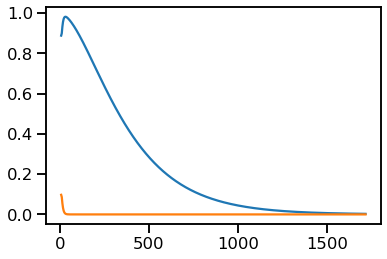

In [47]:
plt.plot(disc_r_range, ratio_uv_list)
plt.plot(disc_r_range, ratio_xray_list)

In [48]:
uv_ratios = np.array(ratio_uv_list)
xray_ratios = np.array(ratio_xray_list)

In [49]:
tot_uv_flux = 0
tot_xray_flux = 0
for i, r in enumerate(disc_r_range):
    flux_r = total_flux_list[i]
    flux_uv = uv_ratios[i] * flux_r
    tot_uv_flux += integrate.simps(x=bh.ENERGY_RANGE_KEV, y = flux_uv / bh.ENERGY_RANGE_KEV) 
    flux_xray = xray_ratios[i] * flux_r
    tot_xray_flux += integrate.simps(x=bh.ENERGY_RANGE_KEV, y = flux_xray / bh.ENERGY_RANGE_KEV) 

In [50]:
tot_uv_flux / integrate.simps(x=bh.ENERGY_RANGE_KEV, y = bh.total_flux(distance) / bh.ENERGY_RANGE_KEV) 

0.861321371268446

In [51]:
(tot_xray_flux + integrate.simps(x=bh.ENERGY_RANGE_KEV, y = bh.corona_flux(distance) / bh.ENERGY_RANGE_KEV) ) / integrate.simps(x=bh.ENERGY_RANGE_KEV, y = bh.total_flux(distance) / bh.ENERGY_RANGE_KEV) 

0.0879957699119467

In [52]:
bh.uv_fraction

0.7215438996724981

In [53]:
bh.xray_fraction

0.19271690480018064